In [1]:
!pwd

/home/giakhang/dev/multi_task_autopilot/YOLOF-Mask/test


In [1]:
%cd /home/giakhang/dev/multi_task_autopilot/YOLOF-Mask

/home/giakhang/dev/multi_task_autopilot/YOLOF-Mask


In [2]:
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate
from detectron2.engine import default_setup

from detectron2.data.datasets import register_coco_instances
from detectron2.data.datasets.coco_panoptic import register_coco_panoptic, register_coco_panoptic_separated

In [3]:
BDD100K_IMG_DIR = "/home/giakhang/dev/multi_task_autopilot/dataset_zoo/bdd100k/images/10k"
DATASET_NAME = "bdd100k"
DETECTRON2_ANNOT_DIR = "/home/giakhang/dev/multi_task_autopilot/da-panopticfpn/datasets/bdd100k_reduced"

PANOPTIC_ROOT = os.path.join(DETECTRON2_ANNOT_DIR, "bdd100k_panoptic_reduced")

for split in ['train', 'val']:
    d_name = DATASET_NAME + f'_{split}'
    register_coco_panoptic_separated(
        d_name, 
        {}, 
        image_root=os.path.join(BDD100K_IMG_DIR, split),
        panoptic_root=os.path.join(PANOPTIC_ROOT, split),
        panoptic_json=os.path.join(DETECTRON2_ANNOT_DIR, f"bdd100k_panoptic_reduced_{split}.json"),
        sem_seg_root=os.path.join(DETECTRON2_ANNOT_DIR, f"{split}_sem_stuff"),
        instances_json=os.path.join(DETECTRON2_ANNOT_DIR, f"bdd100k_instances_reduced_{split}.json"),
    )

In [ ]:
config_file = "/home/giakhang/dev/multi_task_autopilot/YOLOF-Mask/configs/PanopticSegmentation/panoptic_yolof_mask_R_50_1x.py"

cfg = LazyConfig.load(config_file)

# Visualize semantic segmentation only

In [5]:
dataset_dicts = DatasetCatalog.get("bdd100k_train_stuffonly")
metadata = MetadataCatalog.get("bdd100k_train_stuffonly")

metadata.stuff_classes = ["unlabeled", "dynamic", "ego vehicle", "ground", "static",  
    "parking", "rail track", "road", "sidewalk", "bridge", 
    "building", "fence", "garage", "guard rail", "tunnel", 
    "wall", "banner", "billboard", "lane divider", "parking sign", 
    "pole", "polegroup", "street light", "traffic cone",  
    "traffic device", "traffic light", "traffic sign",  
    "traffic sign frame", "terrain", "vegetation", "sky"]

In [6]:
random_sample = random.choice(dataset_dicts)
img_path = random_sample["file_name"]

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

visualizer = Visualizer(img, metadata=metadata, scale=1.0)
out = visualizer.draw_dataset_dict(random_sample)

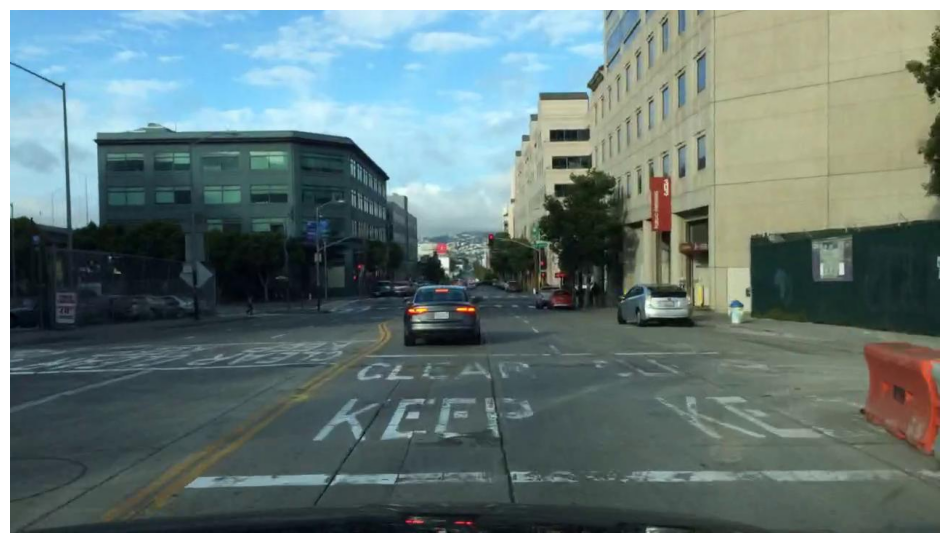

In [7]:
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

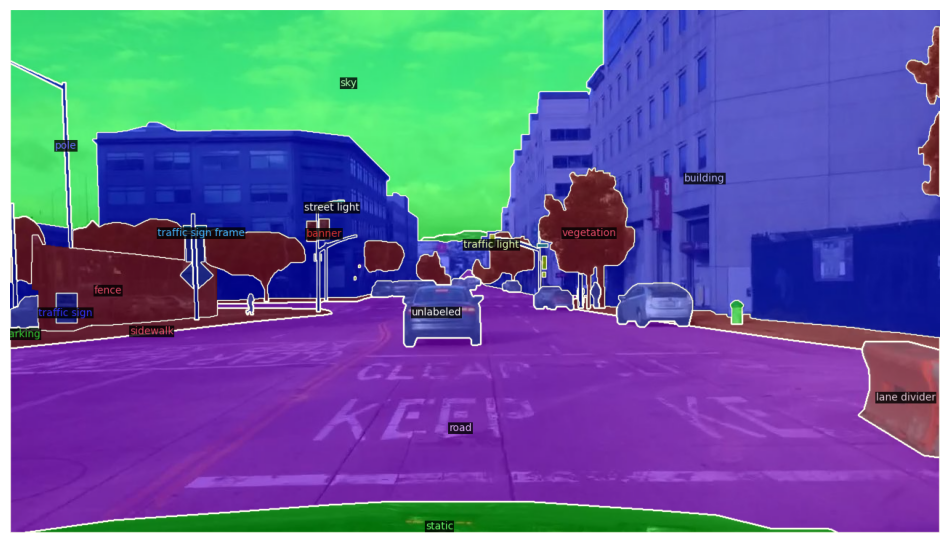

In [8]:
plt.figure(figsize=(12, 8))
plt.imshow(out.get_image())
plt.axis("off")
plt.show()

# Visualize instance segmentation

In [10]:
dataset_dicts = DatasetCatalog.get("bdd100k_train_separated")
metadata = MetadataCatalog.get("bdd100k_train_separated")

metadata.stuff_classes = ["unlabeled", "dynamic", "ego vehicle", "ground", "static",  
    "parking", "rail track", "road", "sidewalk", "bridge", 
    "building", "fence", "garage", "guard rail", "tunnel", 
    "wall", "banner", "billboard", "lane divider", "parking sign", 
    "pole", "polegroup", "street light", "traffic cone",  
    "traffic device", "traffic light", "traffic sign",  
    "traffic sign frame", "terrain", "vegetation", "sky"]


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [11]:
random_sample = random.choice(dataset_dicts)

random_sample.pop("sem_seg_file_name")  # remove this field in order to show instance segmentation only

img_path = random_sample["file_name"]

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

visualizer = Visualizer(img, metadata=metadata, scale=1.0)
out = visualizer.draw_dataset_dict(random_sample)

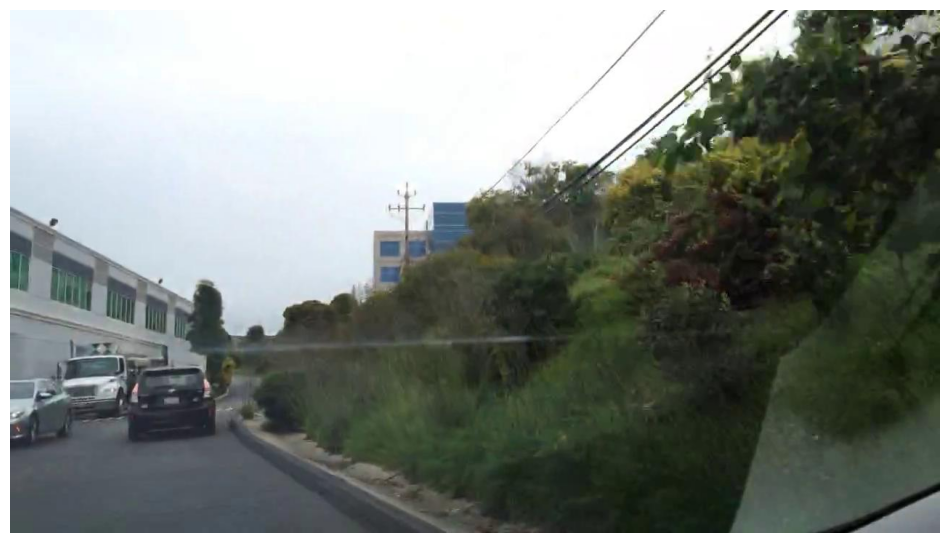

In [12]:
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

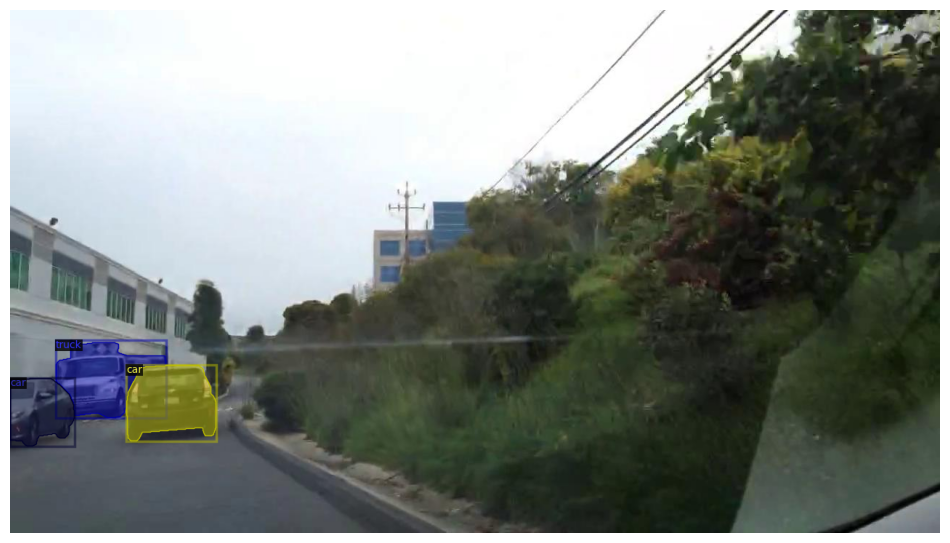

In [13]:
plt.figure(figsize=(12, 8))
plt.imshow(out.get_image())
plt.axis("off")
plt.show()

# Count instances for each category

In [14]:
def get_count_per_class(data: dict) -> dict:
    """
    Count per class given COCO annotations in dict format.
    """
    id_to_class_name = {x['id']: x['name'] for x in data['categories']} 
    annotations = data['annotations']
    
    counts = {}
    for annotation in annotations:
        class_name = id_to_class_name[annotation['category_id']]
        counts[class_name] = counts.get(class_name, 0) + 1
        
    return counts

In [15]:
with open("/home/giakhang/dev/multi_task_autopilot/da-panopticfpn/datasets/bdd100k_reduced/bdd100k_instances_reduced_train.json", 'r') as file:
    data = json.load(file)


In [16]:
ins_per_cat = get_count_per_class(data)
ins_per_cat

{'car': 70661,
 'person': 9800,
 'caravan': 357,
 'bus': 1621,
 'truck': 3697,
 'bicycle': 807,
 'motorcycle': 393,
 'rider': 465,
 'trailer': 105,
 'train': 64}

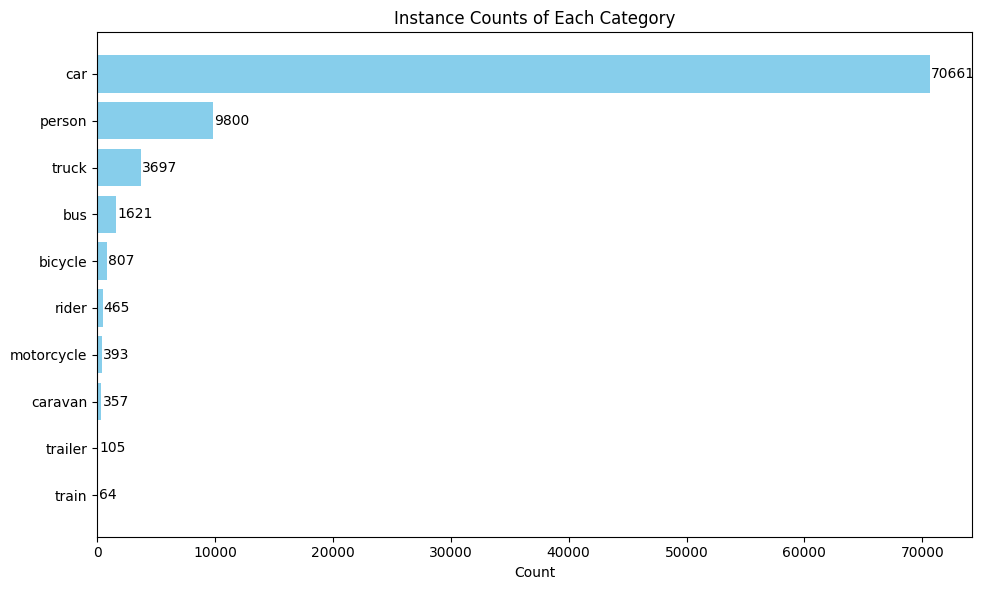

In [17]:
sorted_data = dict(sorted(ins_per_cat.items(), key=lambda item: item[1], reverse=True))

# Extract categories and counts
categories = list(sorted_data.keys())
counts = list(sorted_data.values())

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(categories, counts, color='skyblue')
plt.xlabel('Count')
plt.title('Instance Counts of Each Category')
plt.gca().invert_yaxis()  # Invert y-axis for highest count at the top

# Add count labels on top of each bar
for bar, count in zip(bars, counts):
    plt.text(count + 100, bar.get_y() + bar.get_height()/2, str(count), 
             va='center', ha='left', color='black', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

In [18]:
with open("/home/giakhang/dev/multi_task_autopilot/da-panopticfpn/datasets/bdd100k_reduced/bdd100k_panoptic_reduced_train.json", 'r') as file:
    data = json.load(file)

In [19]:
stuff_counts = dict()

for annotation in data["annotations"]:
    for segment in annotation["segments_info"]:
        category_id = segment["category_id"]
        if 1 <= int(category_id) <= len(metadata.stuff_classes) - 1:
            category_name = metadata.stuff_classes[int(category_id)]
            if category_name in stuff_counts:
                stuff_counts[category_name] += 1
            else:
                stuff_counts[category_name] = 1

In [20]:
stuff_counts

{'ego vehicle': 5497,
 'static': 5720,
 'road': 6752,
 'building': 6189,
 'fence': 2140,
 'banner': 1029,
 'pole': 6649,
 'traffic light': 3294,
 'traffic sign': 5270,
 'traffic sign frame': 1439,
 'vegetation': 6422,
 'sky': 6635,
 'sidewalk': 4667,
 'lane divider': 518,
 'street light': 4538,
 'terrain': 2566,
 'ground': 1230,
 'billboard': 1391,
 'dynamic': 1910,
 'bridge': 1136,
 'guard rail': 1857,
 'wall': 1077,
 'polegroup': 311,
 'traffic cone': 361,
 'parking': 653,
 'parking sign': 290,
 'traffic device': 370,
 'tunnel': 100,
 'garage': 64,
 'rail track': 70}

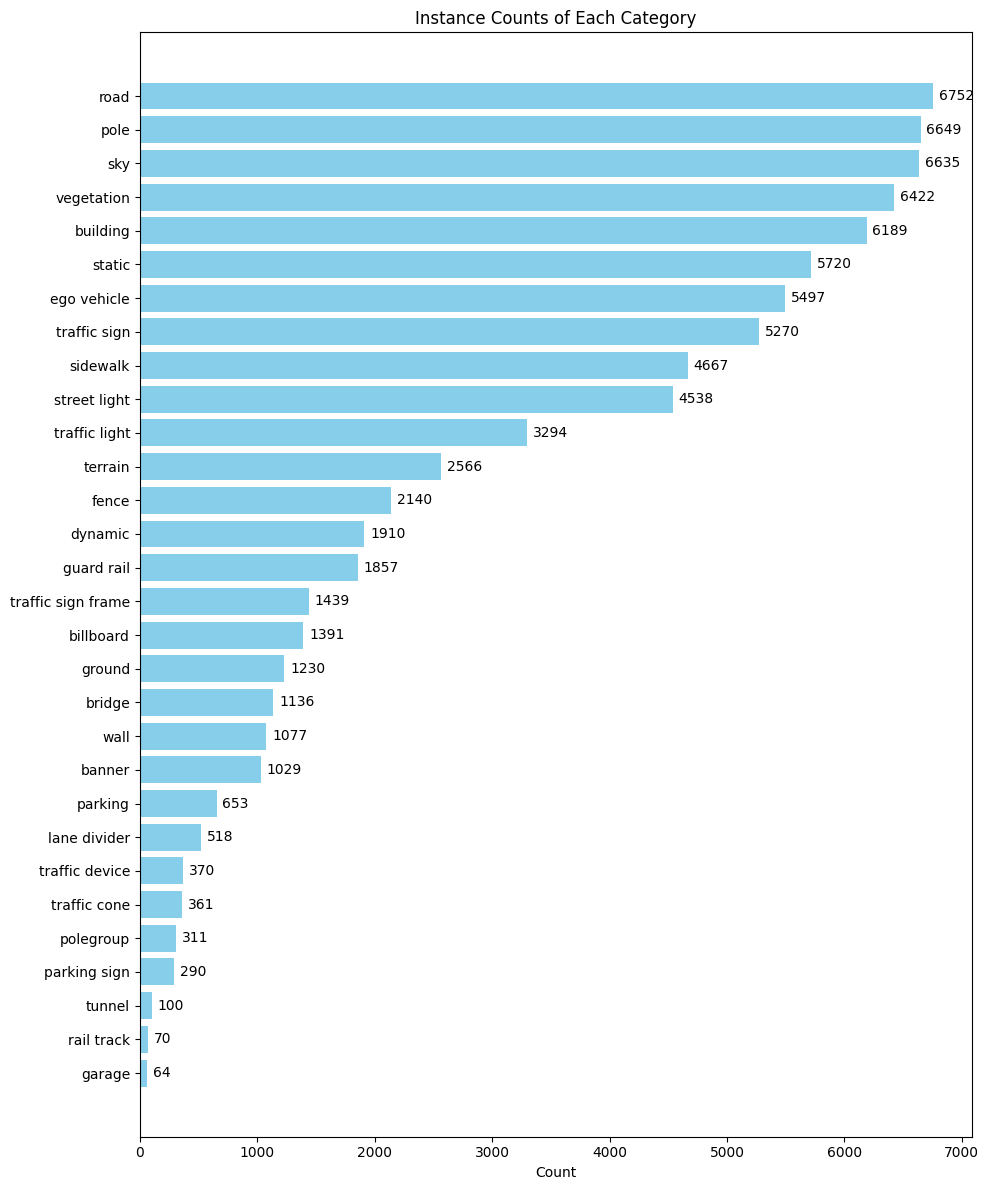

In [21]:
sorted_data = dict(sorted(stuff_counts.items(), key=lambda item: item[1], reverse=True))

# Extract categories and counts
categories = list(sorted_data.keys())
counts = list(sorted_data.values())

# Plot
plt.figure(figsize=(10, 12))
bars = plt.barh(categories, counts, color='skyblue')
plt.xlabel('Count')
plt.title('Instance Counts of Each Category')
plt.gca().invert_yaxis()  # Invert y-axis for highest count at the top

# Add count labels on top of each bar
for bar, count in zip(bars, counts):
    plt.text(count + 50, bar.get_y() + bar.get_height()/2, str(count), 
             va='center', ha='left', color='black', fontsize=10)

# Show plot
plt.tight_layout()
plt.savefig("count_sem_seg.png")
plt.show()

# Test dataloader

In [22]:
train_loader = instantiate(cfg.dataloader.train)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [23]:
imgs = next(iter(train_loader))

In [24]:
imgs[0]["sem_seg"].shape

torch.Size([736, 1308])

In [25]:
imgs[0]['instances']

Instances(num_instances=10, image_height=736, image_width=1308, fields=[gt_boxes: Boxes(tensor([[1007.5687,  422.1778, 1047.4219,  444.6667],
        [1128.1500,  423.2000, 1186.3969,  455.9111],
        [1056.6188,  418.0889, 1145.5219,  456.9333],
        [ 815.4562,  412.9778,  824.6531,  427.2889],
        [ 724.5094,  389.4667,  759.2531,  425.2444],
        [ 741.8812,  405.8222,  800.1281,  447.7333],
        [ 827.7188,  398.6667, 1031.0719,  526.4445],
        [ 596.7750,  402.7556,  630.4969,  430.3556],
        [ 624.3656,  383.3333,  739.8375,  487.6000],
        [ 510.9375,  402.7556,  583.4906,  451.8222]])), gt_classes: tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4]), gt_masks: BitMasks(num_instances=10)])